In [ ]:
pip install scipy==1.1.0

     |████████████████████████████████| 31.2 MB 12.4 MB/s eta 0:00:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.6.2
    Uninstalling scipy-1.6.2:
      Successfully uninstalled scipy-1.6.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-model-analysis 0.28.0 requires pyarrow<3,>=1, but you have pyarrow 3.0.0 which is incompatible.
tensorflow-model-analysis 0.28.0 requires scipy<2,>=1.4.1, but you have scipy 1.1.0 which is incompatible.
phik 0.11.2 requires scipy>=1.5.2, but you have scipy 1.1.0 which is incompatible.
pandas-profiling 2.11.0 requires scipy>=1.4.1, but you have scipy 1.1.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
from scipy.misc import imresize

%matplotlib inline

import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import h5py
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model

Using TensorFlow backend.


### Download the Food-101 dataset

In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz

--2021-05-08 13:16:13--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2021-05-08 13:16:13--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G   173MB/s    in 27s     

2021-05-08 13:16:40 (177 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]



In [ ]:
!tar xzvf food-101.tar.gz

food-101/
food-101/images/
food-101/images/beignets/
food-101/images/beignets/2885220.jpg
food-101/images/beignets/1814040.jpg
food-101/images/beignets/81202.jpg
food-101/images/beignets/1827892.jpg
food-101/images/beignets/2802124.jpg
food-101/images/beignets/2192983.jpg
food-101/images/beignets/250043.jpg
food-101/images/beignets/2786548.jpg
food-101/images/beignets/445116.jpg
food-101/images/beignets/3661460.jpg
food-101/images/beignets/1064858.jpg
food-101/images/beignets/2993714.jpg
food-101/images/beignets/2936669.jpg
food-101/images/beignets/1062952.jpg
food-101/images/beignets/2869806.jpg
food-101/images/beignets/178659.jpg
food-101/images/beignets/1261083.jpg
food-101/images/beignets/1296128.jpg
food-101/images/beignets/3157161.jpg
food-101/images/beignets/646871.jpg
food-101/images/beignets/3438314.jpg
food-101/images/beignets/3019700.jpg
food-101/images/beignets/1133765.jpg
food-101/images/beignets/1199143.jpg
food-101/images/beignets/287665.jpg
food-101/images/beignets/3452

In [ ]:
!ls food-101/images

apple_pie	    eggs_benedict	     onion_rings
baby_back_ribs	    escargots		     oysters
baklava		    falafel		     pad_thai
beef_carpaccio	    filet_mignon	     paella
beef_tartare	    fish_and_chips	     pancakes
beet_salad	    foie_gras		     panna_cotta
beignets	    french_fries	     peking_duck
bibimbap	    french_onion_soup	     pho
bread_pudding	    french_toast	     pizza
breakfast_burrito   fried_calamari	     pork_chop
bruschetta	    fried_rice		     poutine
caesar_salad	    frozen_yogurt	     prime_rib
cannoli		    garlic_bread	     pulled_pork_sandwich
caprese_salad	    gnocchi		     ramen
carrot_cake	    greek_salad		     ravioli
ceviche		    grilled_cheese_sandwich  red_velvet_cake
cheese_plate	    grilled_salmon	     risotto
cheesecake	    guacamole		     samosa
chicken_curry	    gyoza		     sashimi
chicken_quesadilla  hamburger		     scallops
chicken_wings	    hot_and_sour_soup	     seaweed_salad
chocolate_cake	    hot_dog		     shrimp_and_grits
chocolate_mousse    huevo

### Preprocess: Divide the Food-101 dataset to train and test folder

In [ ]:
from shutil import copy
class_image = defaultdict(list)
with open('food-101/meta/train.txt', 'r') as txt:
    classes = [read.strip() for read in txt.readlines()]
    for c in classes:
      food_class = c.split('/')
      class_image[food_class[0]].append(food_class[1] + '.jpg')
for c in class_image.keys():
  if not os.path.exists(os.path.join('food-101/train', c)):
    os.makedirs(os.path.join('food-101/train', c))
  for img in class_image[c]:
    copy(os.path.join('food-101/images', c, img), os.path.join('food-101/train', c, img))

In [ ]:
class_image = defaultdict(list)
with open('food-101/meta/test.txt', 'r') as txt:
    classes = [read.strip() for read in txt.readlines()]
    for c in classes:
      food_class = c.split('/')
      class_image[food_class[0]].append(food_class[1] + '.jpg')
for c in class_image.keys():
  os.makedirs(os.path.join('food-101/test', c))
  for img in class_image[c]:
    copy(os.path.join('food-101/images', c, img), os.path.join('food-101/test', c, img))

### Select 60 classes from the train and test folder

In [ ]:
from shutil import copytree
arr = ["apple_pie","baby_back_ribs","baklava","bread_pudding","breakfast_burrito","bruschetta","caesar_salad","caprese_salad","carrot_cake","ceviche","cheesecake","chicken_curry","chicken_quesadilla","chicken_wings","chocolate_cake","chocolate_mousse","churros","clam_chowder","crab_cakes","creme_brulee","deviled_eggs","donuts","dumplings","edamame","falafel","french_fries","french_onion_soup","french_toast","frozen_yogurt","garlic_bread","gnocchi","greek_salad","grilled_salmon","guacamole","hamburger","hot_dog","huevos_rancheros","hummus","ice_cream","lasagna","lobster_bisque","macaroni_and_cheese","miso_soup","mussels","onion_rings","pad_thai","paella","pancakes","pizza","ramen","ravioli","red_velvet_cake","risotto","scallops","seaweed_salad","spaghetti_bolognese","spring_rolls","strawberry_shortcake","tiramisu","waffles"]
os.makedirs('food-101/train_60')
for c in arr :
  copytree(os.path.join('food-101/train',c), os.path.join('food-101/train_60',c))

In [ ]:
os.makedirs('food-101/test_60')
for c in arr :
  copytree(os.path.join('food-101/test',c), os.path.join('food-101/test_60',c))

### Show one image from each of the 60 classes

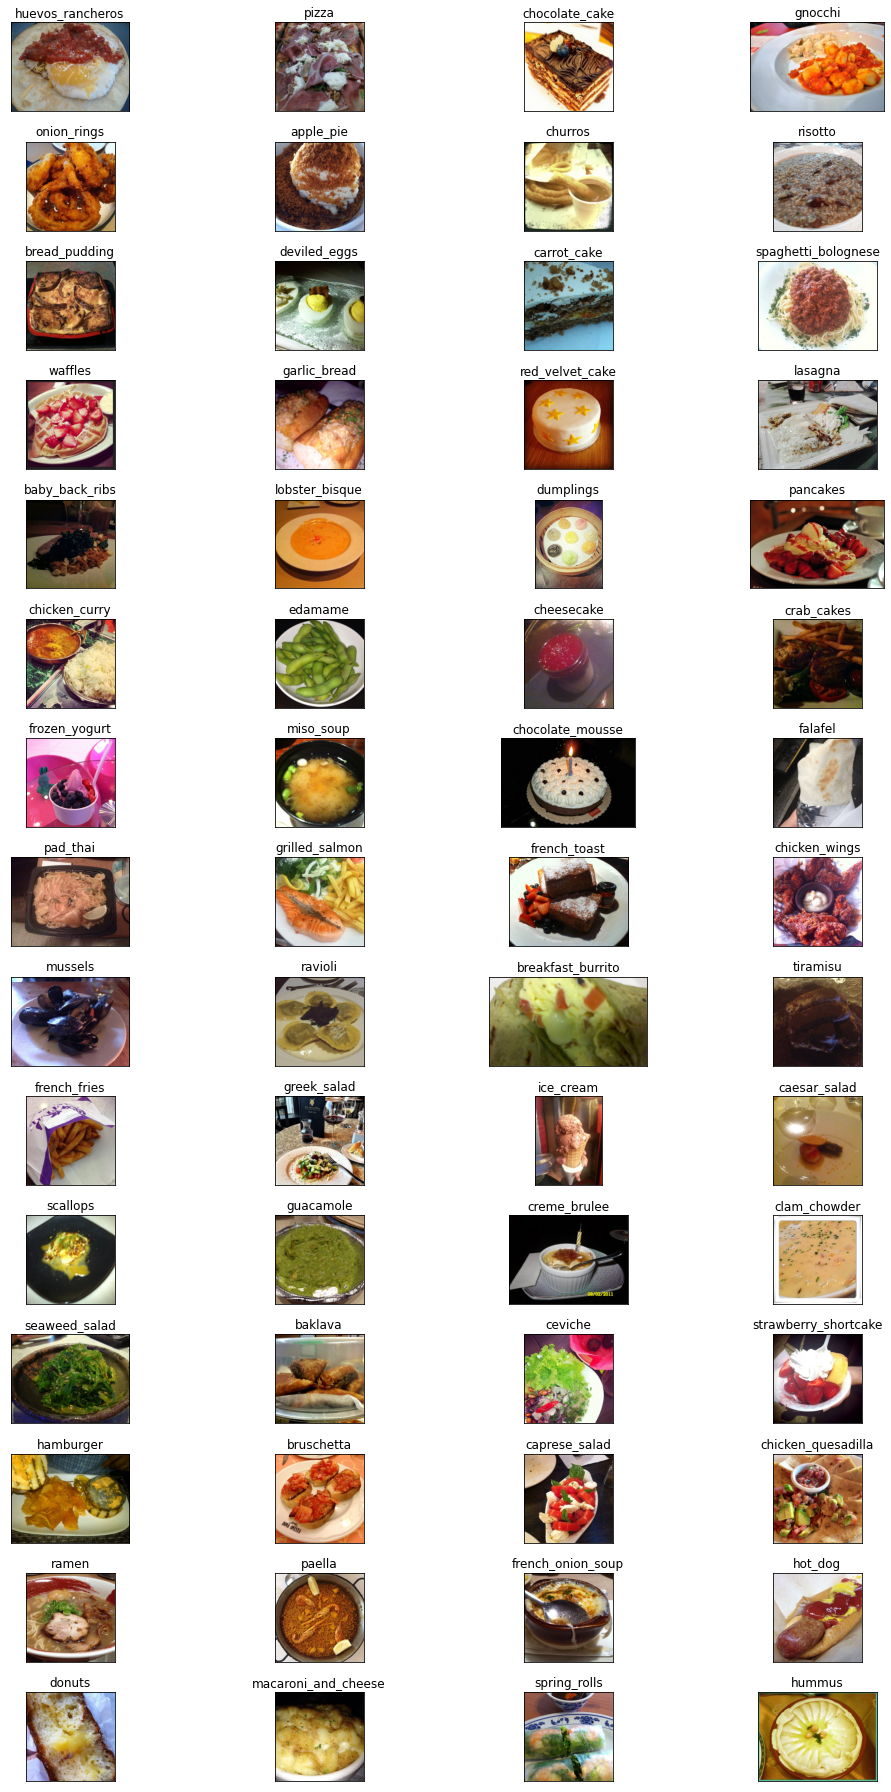

In [ ]:
plt.rcParams['savefig.facecolor'] = "0.8"
plt.close('all')
row = 15
col = 4
fig, ax = plt.subplots(row, col, figsize=(15,25))
index = 0;
all_class = os.listdir("food-101/train_60/")
for i in range(row):
  for j in range(col):
    if index < 101:
      all_image = os.listdir(os.path.join("food-101/train_60/",all_class[index]))
      image = np.random.choice(all_image)
      img = plt.imread(os.path.join("food-101/train_60/",all_class[index], image))
      ax[i][j].imshow(img)
      ax[i][j].set_title(all_class[index])
      index = index + 1
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()

### Image data augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator 
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        'food-101/train_60',
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
        'food-101/test_60',
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical')

Found 45000 images belonging to 60 classes.
Found 15000 images belonging to 60 classes.


### Train the model

In [ ]:
def scheduler(epoch):
  lr = 1e-2
  if epoch > 20:
    lr = 0.5e-3
  elif epoch > 10:
    lr = 1e-3
  return lr

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.layers import Input
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import SGD
from tensorflow.keras import regularizers
from keras.regularizers import l2
import keras.backend as K
import math

K.clear_session()
test_num = 15000
train_num = 45000
batch_size= 32
n_classes = 60
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(.2)(x)
predictions = Dense(n_classes, kernel_regularizer=regularizers.l2(0.0005), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=SGD(lr=.01, momentum=.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='InceptionV3_model.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('InceptionV3_model.log')

lr_scheduler = LearningRateScheduler(scheduler)

model.fit_generator(train_generator,
                    validation_data=test_generator,
                    validation_steps=test_num // batch_size,
                    steps_per_epoch=train_num // batch_size,
                    epochs=32,
                    verbose=1,
                    callbacks=[lr_scheduler, csv_logger, checkpointer])

87916544/87910968 [==============================] - 1s 0us/step


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/32
1406/1406 [==============================] - 1020s 710ms/step - loss: 2.5355 - accuracy: 0.3801 - val_loss: 2.3702 - val_accuracy: 0.4119

Epoch 00001: val_loss improved from inf to 2.37022, saving model to InceptionV3_model.hdf5
Epoch 2/32
1406/1406 [==============================] - 993s 706ms/step - loss: 1.4162 - accuracy: 0.6364 - val_loss: 2.1168 - val_accuracy: 0.5214

Epoch 00002: val_loss improved from 2.37022 to 2.11678, saving model to InceptionV3_model.hdf5
Epoch 3/32
1406/1406 [==============================] - 981s 698ms/step - loss: 1.1505 - accuracy: 0.7025 - val_loss: 1.5325 - val_accuracy: 0.6232

Epoch 00003: val_loss improved from 2.11678 to 1.53245, saving model to InceptionV3_model.hdf5
Epoch 4/32
1406/1406 [==============================] - 983s 699ms/step - loss: 0.9667 - accuracy: 0.7531 - val_loss: 1.5117 - val_accuracy: 0.6357

Epoch 00004: val_loss improved from 1.53245 to 1.51173, saving model to InceptionV3_model.hdf5
Epoch 5/32
1406/1406 [=====

### Test the model

In [ ]:
model = load_model(filepath='./InceptionV3_model.hdf5')

In [ ]:
def preprocess_img(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

waffles


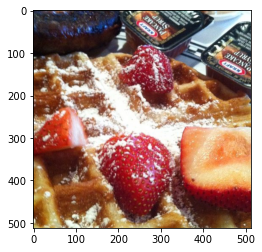

In [ ]:
from PIL import Image
from keras.preprocessing import image

test_image = Image.open('food-101/test_60/waffles/1005755.jpg')
img = image.load_img('food-101/test_60/waffles/1005755.jpg', target_size=(299, 299))
img_arr = image.img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)
img_arr_test = preprocess_img(img_arr)
y_pred = model.predict(img_arr_test)
preds = np.argmax(y_pred, axis=1)
best_pred = collections.Counter(preds).most_common(1)[0][0]
print(arr[best_pred])
plt.imshow(test_image)